In [1]:
%matplotlib inline

import io, os, sys, types, datetime, pickle, warnings

import pandas as pd
import numpy as np
import scipy.optimize as opt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.pylab as pl

warnings.filterwarnings('ignore')

In [2]:
master_path = os.getcwd()
if master_path not in sys.path:
    sys.path.append(master_path)

In [3]:
def parse_folder_info(path):
    folders = [f for f in os.listdir(path) if not os.path.isfile(os.path.join(path, f))]
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    if('.DS_Store' in files):
        files.remove('.DS_Store')
    if('._.DS_Store' in files):
        files.remove('._.DS_Store')
    return folders, files

In [4]:
def get_time_columns(columns):
    time_str = []
    time_datetime = []
    for col in columns:
        if col[0].isnumeric():
            time_str.append(col)
            time_datetime.append(datetime.datetime.strptime(col, '%m/%d/%y'))
    return time_str, time_datetime

In [5]:
def format_fn(tick_val, tick_pos):
    if(tick_val >= 0 and tick_val < len(time_str)):
        return time_str[int(tick_val)]
    else:
        return int(tick_val)

In [6]:
def autolabel(rects, ax, str_format):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(str_format.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [7]:
def exp_growth(t, r, x0):
#     return np.log10(x0) + t * np.log10(1+r)
    return x0 * (1 + r) ** t

In [8]:
def logistic_growth(t, r, K, P0):
    return K / (1 + (K - P0)/P0 * np.exp(-r*t))

In [9]:
def get_moving_avg(arr, num):
    if(len(arr.shape) == 2):
        moving_avg = np.zeros((arr.shape[0]-num-1, arr.shape[1]))
        for i in range(1, arr.shape[0]-num):
            moving_avg[i-1,:] = np.mean(arr[i:i+num,:], axis = 0) / np.mean(arr[i-1:i+num-1,:], axis = 0)
        moving_avg[~np.isfinite(moving_avg)] = 0
    elif(len(arr.shape) == 1):
        moving_avg = np.zeros((arr.shape[0]-num-1))
        for i in range(1, arr.shape[0]-num):
            moving_avg[i-1] = np.mean(arr[i:i+num]) / np.mean(arr[i-1:i+num-1])
        moving_avg[~np.isfinite(moving_avg)] = 0
    return moving_avg
         

In [10]:
def reshape_dataframe(df, time_str):
    if('Confirmed' in df.index):
        df = df.transpose()
        df.rename_axis('Date', inplace = True)
        df['Active'] = df['Confirmed'] - (df['Deaths'] + df['Recovered'])
        df['Fatality_rate'] = df['Deaths']/df['Confirmed'] * 100
        df['Recovered_prop'] = df.Recovered/(df.Deaths + df.Recovered) * 100
        df['Death_prop'] = df.Deaths/(df.Deaths + df.Recovered) * 100
    else:
        df.rename(columns = {df.columns[0]:'Confirmed'}, inplace = True)
        df.rename_axis('Date', inplace = True)
    df['Daily'] = df['Confirmed'].diff()
    l1 = df.loc[time_str[2:],'Daily'].to_list()
    l2 = df.loc[time_str[1:-1],'Daily'].to_list()
    df.loc[time_str[2:],'GF'] = np.divide(l1, l2)
    df['GF_rolling_thr'] = df.GF.rolling(window = 3).mean()
    df[~np.isfinite(df)] = 0
    df['GF_rolling'] = df.GF.rolling(window = 3).mean()
    df[~np.isfinite(df)] = 0
    return df

In [11]:
"""Get Data"""

'Get Data'

In [12]:
cat_color = {'Confirmed':'tab:blue', 'Deaths':'tab:orange', 'Recovered':'tab:green', 'Active':'tab:red'}

In [13]:
path_time_series = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_time_series')
path_daily = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_daily_reports')
today_csv = '03-14-2020.csv'
today = '3/14/20'
folders, files = parse_folder_info(path_time_series)
df_time_series = pd.DataFrame()
# df_time_series_reorged = pd.DataFrame(columns = ['Country/Region', 'Province/State', 'Date', 'Category', 'Number'])
for file_name in files:
    if('.csv' in file_name):
        df_current = pd.read_csv(os.path.join(path_time_series, file_name))        
        category = file_name[21:file_name.index('.csv')]
        print(category)
        df_current.loc[:,'Category'] = category
        if df_time_series.empty:
            df_time_series = df_current
        else:
            df_time_series = df_time_series.append(df_current, ignore_index = True)
time_str, time_datetime = get_time_columns(df_time_series.columns)
df_today = pd.read_csv(os.path.join(path_daily, today_csv))

df_time_series.loc[df_time_series.loc[:,'Province/State'].isna(),'Province/State'] = 'N/A'
df_today.loc[df_today.loc[:,'Province/State'].isna(), 'Province/State'] = 'N/A'
# df_time_series.loc[:,'New Today'] = df_time_series.loc[:,time_str[-1]] - df_time_series.loc[:,time_str[-2]]

Recovered
Deaths
Confirmed


In [14]:
### fix 3/12/20 datapoints

In [15]:
alt_cols = ['3/12/20', '3/15/20']

In [16]:
df_alteration = pd.read_csv(os.path.join(master_path, 'time_series_19-covid_alteration.csv'))
df_alteration.set_index('Country/Region', inplace = True)

In [17]:
for ctry in df_alteration.index:
    ind = (df_time_series['Category'] == 'Confirmed') & (df_time_series['Country/Region'] == ctry)
    if(np.sum(ind) > 1):
        ind = ind & (df_time_series['Province/State'] == ctry)
    for col in alt_cols:
        if not pd.isna(df_alteration.loc[ctry, col]):
            df_time_series.loc[ind, col] = df_alteration.loc[ctry, col]

In [18]:
""" Total Recovered, death, and confirmed """

' Total Recovered, death, and confirmed '

In [19]:
df_total = df_time_series.groupby('Category').sum().loc[:,time_str]
df_mc = df_time_series.groupby('Country/Region').get_group('China').groupby('Category').sum().loc[:,time_str]
df_row = df_total - df_mc
df_hb = df_time_series.groupby('Country/Region').get_group('China').groupby('Province/State').get_group('Hubei').groupby('Category').sum().loc[:,time_str]
df_co = df_mc - df_hb

In [20]:
df_total = reshape_dataframe(df_total, time_str)
df_mc = reshape_dataframe(df_mc, time_str)
df_row = reshape_dataframe(df_row, time_str)
df_hb = reshape_dataframe(df_hb, time_str)
df_co = reshape_dataframe(df_co, time_str)

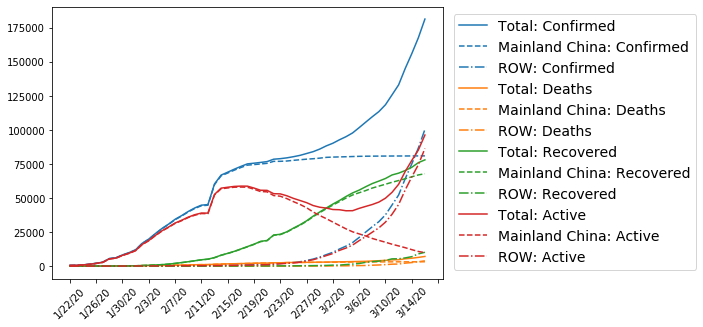

In [21]:
fig, ax1 = plt.subplots(1,1,figsize = (7,5))
for cat in cat_color:
    ax1.plot(df_total.loc[:,cat], color = cat_color[cat])
    ax1.plot(df_mc.loc[:,cat], '--', color = cat_color[cat])
    ax1.plot(df_row.loc[:,cat], '-.', color = cat_color[cat])
legend = ['Total: Confirmed',
         'Mainland China: Confirmed',
          'ROW: Confirmed',
         'Total: Deaths',
         'Mainland China: Deaths',
          'ROW: Deaths',
         'Total: Recovered',
         'Mainland China: Recovered',
          'ROW: Recovered',
         'Total: Active',
         'Mainland China: Active',
         'ROW: Active']
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
# ax1.set_title('Total', size = 18)
plt.legend(legend, bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, fontsize = 14)

In [22]:
x = np.arange(len(time_str))
y = np.zeros((len(time_str), 2))

y[:,0] = df_mc.Confirmed.to_list()
y[:,1] = df_row.Confirmed.to_list()

popt_exp = []
popt_log = []
for i in [0, 1]:
    p, cov = opt.curve_fit(exp_growth,  x,  y[:,i], p0 = (0.1, 100), maxfev=100000)
    popt_exp.append(list(p))
    p, cov = opt.curve_fit(logistic_growth,  x,  y[:,i], p0 = (0.1, 100, 1), maxfev=100000)
    popt_log.append(list(p))

Text(0.5, 1.0, 'ROW: Closed Cases')

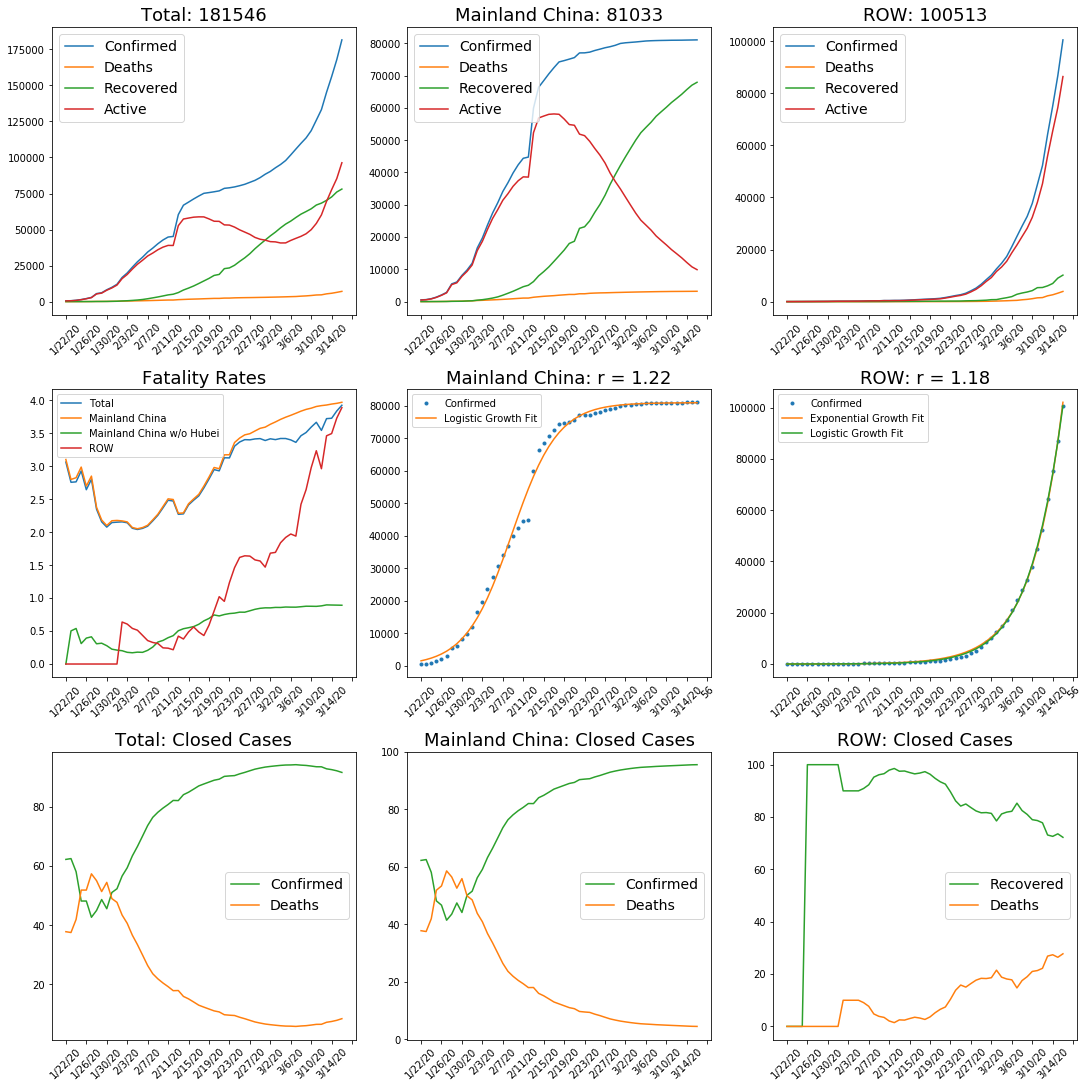

In [23]:
cat_cols = list(cat_color.keys())

fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(3,3)

### total confirmed/recovered/death/active
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_total[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(cat_cols, fontsize = 14)
ax1.set_title(f"Total: {int(df_total.loc[time_str[-1], 'Confirmed'])}", size = 18)

### mainland china confirmed/recovered/death/active
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_mc[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = 14)
ax2.set_title(f'Mainland China: {int(df_mc.loc[time_str[-1], "Confirmed"])}', size = 18)

### rest of the world confirmed/recovered/death/active
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(df_row[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(cat_cols, fontsize = 14)
ax3.set_title(f'ROW: {int(df_row.loc[time_str[-1], "Confirmed"])}', size = 18)

### fatality rates
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(df_total.loc[:,'Fatality_rate'])
ax4.plot(df_mc.loc[:,'Fatality_rate'])
ax4.plot(df_co.loc[:,'Fatality_rate'])
ax4.plot(df_row.loc[:,'Fatality_rate'])
plt.legend(['Total',
            'Mainland China',
            'Mainland China w/o Hubei',
            'ROW'
           ])
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.set_title('Fatality Rates', fontsize = 18)

### mainland China fit
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(x, y[:,0], '.')
ax5.plot(x, logistic_growth(x, popt_log[0][0], popt_log[0][1], popt_log[0][2]))
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(['Confirmed', 'Logistic Growth Fit'])
ax5.set_title(f'Mainland China: r = {popt_log[0][0]+1:.2f}', fontsize = 18)

### ROW fit
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(x, y[:,1], '.')
ax6.plot(x, exp_growth(x, popt_exp[1][0], popt_exp[1][1]))
ax6.plot(x, logistic_growth(x, popt_log[1][0], popt_log[1][1], popt_log[1][2]))
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.tick_params(axis = 'x', labelrotation = 45)
ax6.legend(['Confirmed', 'Exponential Growth Fit', 'Logistic Growth Fit'])
ax6.set_title(f'ROW: r = {popt_log[1][0]+1:.2f}', fontsize = 18)
              
### total closed cases
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(df_total.Recovered_prop, color = cat_color['Recovered'])
ax7.plot(df_total.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax7.xaxis.set_major_locator(myLocator)
ax7.tick_params(axis = 'x', labelrotation = 45)
ax7.legend(cat_cols, fontsize = 14)
ax7.set_title('Total: Closed Cases', size = 18)

### mainland china closed cases
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(df_mc.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_mc.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(cat_cols, fontsize = 14)
ax8.set_title('Mainland China: Closed Cases', size = 18)

### rest of the world closed cases
ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(df_row.Recovered_prop, color = cat_color['Recovered'])
ax9.plot(df_row.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax9.xaxis.set_major_locator(myLocator)
ax9.tick_params(axis = 'x', labelrotation = 45)
ax9.legend(['Recovered', 'Deaths'], fontsize = 14)
ax9.set_title('ROW: Closed Cases', size = 18)

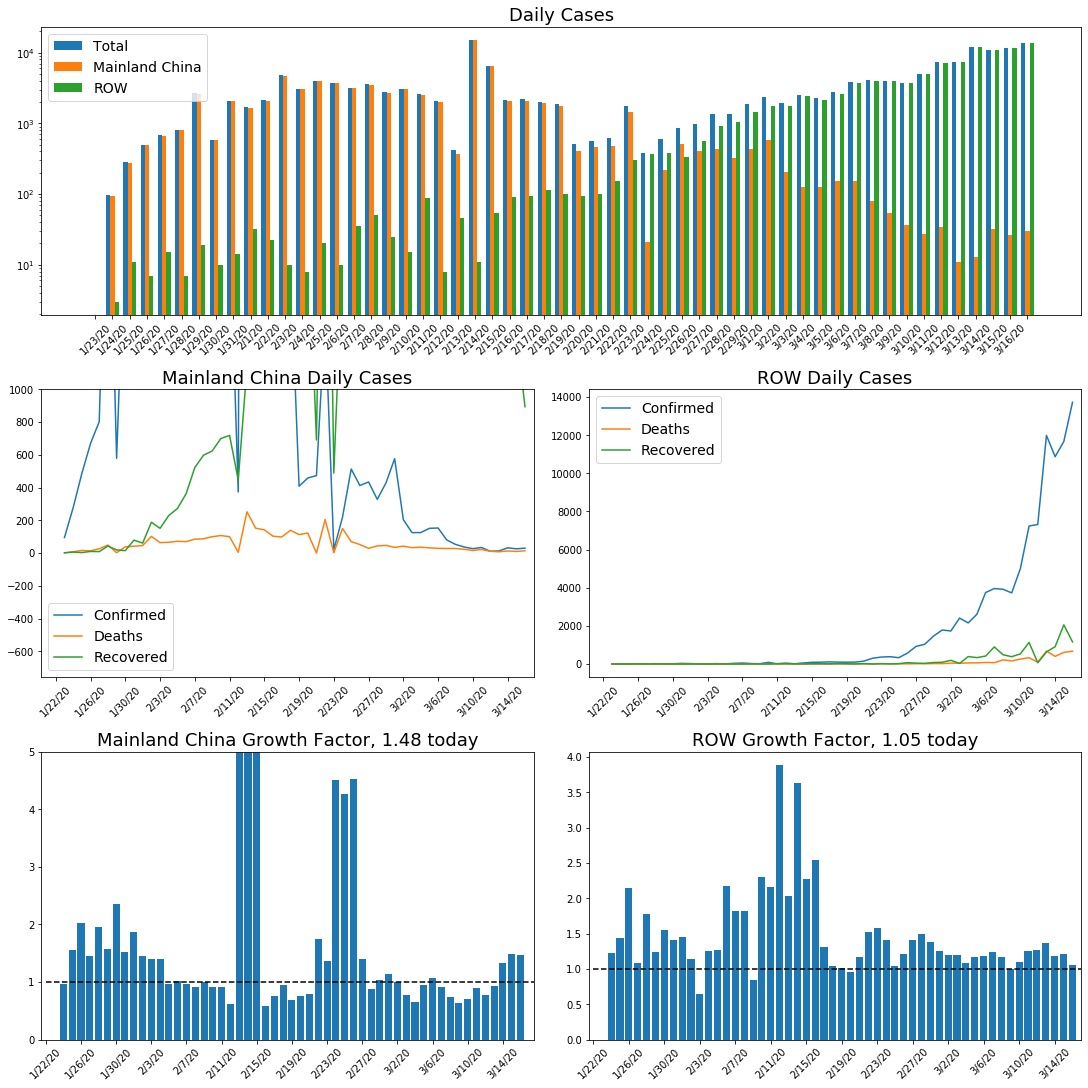

In [24]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(3,2)

### Mainland China daily confirmed/recovered/deaths/active
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(df_mc[cat_cols[:-1]].diff())
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.set_ylim(top = 1000)
ax2.set_xlim(right = len(time_str))
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = 14)
ax2.set_title('Mainland China Daily Cases', size = 18)

### ROW daily confirmed/recovered/deaths/active
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(df_row[cat_cols[:-1]].diff())
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.set_xlim(right = len(time_str))
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(cat_cols, fontsize = 14)
ax3.set_title('ROW Daily Cases', size = 18)

# ### Daily Confirmed cases
ax1 = fig.add_subplot(gs[0, :])

# total_daily = total.loc['Confirmed',:].to_numpy()[1:] - total.loc['Confirmed',:].to_numpy()[:-1]
# mc_daily = mainland_china.loc['Confirmed',:].to_numpy()[1:] - mainland_china.loc['Confirmed',:].to_numpy()[0:-1]
# row_daily = row.loc['Confirmed',:].to_numpy()[1:] - row.loc['Confirmed',:].to_numpy()[0:-1]
x = np.arange(len(time_str))
width = 0.25

ax1.bar(x + 0, df_total.loc[:,'Daily'], width = width)
ax1.bar(x + width*1, df_mc.loc[:,'Daily'], width = width)
ax1.bar(x + width*2, df_row.loc[:,'Daily'], width = width)
ax1.set_yscale('log')
# ax4.set_ylim([0, 5000])
_ = ax1.set_xticks(x + width)
_ = ax1.set_xticklabels(time_str[1:])
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(['Total', 'Mainland China', 'ROW'], fontsize = 14, loc='upper left')
ax1.set_title('Daily Cases', size = 18)

# ### Mainland China Growth Factor
ax5 = fig.add_subplot(gs[2, 0])

x = np.arange(0, len(time_str))
x1 = np.arange(0, len(time_str) + 2)

ax5.bar(x, df_mc.GF_rolling)
ax5.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.set_xlim([-0.5, len(time_str)+0.5])
ax5.set_ylim(top = 5, bottom = 0)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.set_title(f'Mainland China Growth Factor, {df_mc.GF_rolling[-1]:.2f} today', size = 18)

### ROW Growth Factor
ax6 = fig.add_subplot(gs[2, 1])
ax6.bar(x, df_row.GF_rolling)
ax6.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.set_xlim([-0.5, len(time_str)])
ax6.tick_params(axis = 'x', labelrotation = 45)
_ = ax6.set_title(f'ROW Growth Factor, {df_row.GF_rolling[-1]:.2f} today', size = 18)

In [25]:
"""US"""

'US'

In [26]:
df_US = df_time_series.groupby(['Country/Region']).get_group(('US'))
df_CA = pd.DataFrame()
df_DP = pd.DataFrame()
df_USmain = pd.DataFrame()
df_GP = pd.DataFrame()

for i in df_US.index:
    if ('CA' in df_US.loc[i, 'Province/State'] or 'California' in df_US.loc[i, 'Province/State']):
        if('(From Diamond Princess)' not in df_US.loc[i, 'Province/State']) :
            df_CA = df_CA.append(df_US.loc[i,:])
    if('Diamond Princess'in df_US.loc[i, 'Province/State']) :
        df_DP = df_DP.append(df_US.loc[i,:])
    if('Grand Princess' in df_US.loc[i, 'Province/State']):
        df_GP = df_GP.append(df_US.loc[i,:])
    else:
        df_USmain = df_USmain.append(df_US.loc[i,:])
# df_US_sum = df_US.groupby('Category').sum().loc[:,time_str]
# df_Ca_sum = df_Ca.groupby('Category').sum().loc[:,time_str]
# df_DP_sum = df_DP.groupby('Category').sum().loc[:,time_str]
# df_USmain_sum = df_USmain.groupby('Category').sum().loc[:,time_str]
# df_GP_sum = df_GP.groupby('Category').sum().loc[:,time_str]

# df_US_sum.loc['Active',:] = df_US_sum.loc['Confirmed',:] - (df_US_sum.loc['Recovered',:] + df_US_sum.loc['Deaths',:])
# df_Ca_sum.loc['Active',:] = df_Ca_sum.loc['Confirmed',:] - (df_Ca_sum.loc['Recovered',:] + df_Ca_sum.loc['Deaths',:])
# df_DP_sum.loc['Active',:] = df_DP_sum.loc['Confirmed',:] - (df_DP_sum.loc['Recovered',:] + df_DP_sum.loc['Deaths',:])
# df_USmain_sum.loc['Active',:] = df_USmain_sum.loc['Confirmed',:] - (df_USmain_sum.loc['Recovered',:] + df_USmain_sum.loc['Deaths',:])
# df_GP_sum.loc['Active',:] = df_GP_sum.loc['Confirmed',:] - (df_GP_sum.loc['Recovered',:] + df_GP_sum.loc['Deaths',:])

In [27]:
df_US = reshape_dataframe(df_US.groupby('Category').sum().loc[:,time_str], time_str)
df_CA = reshape_dataframe(df_CA.groupby('Category').sum().loc[:,time_str], time_str)
df_USmain = reshape_dataframe(df_USmain.groupby('Category').sum().loc[:,time_str], time_str)
df_DP = reshape_dataframe(df_DP.groupby('Category').sum().loc[:,time_str], time_str)
df_GP = reshape_dataframe(df_GP.groupby('Category').sum().loc[:,time_str], time_str)

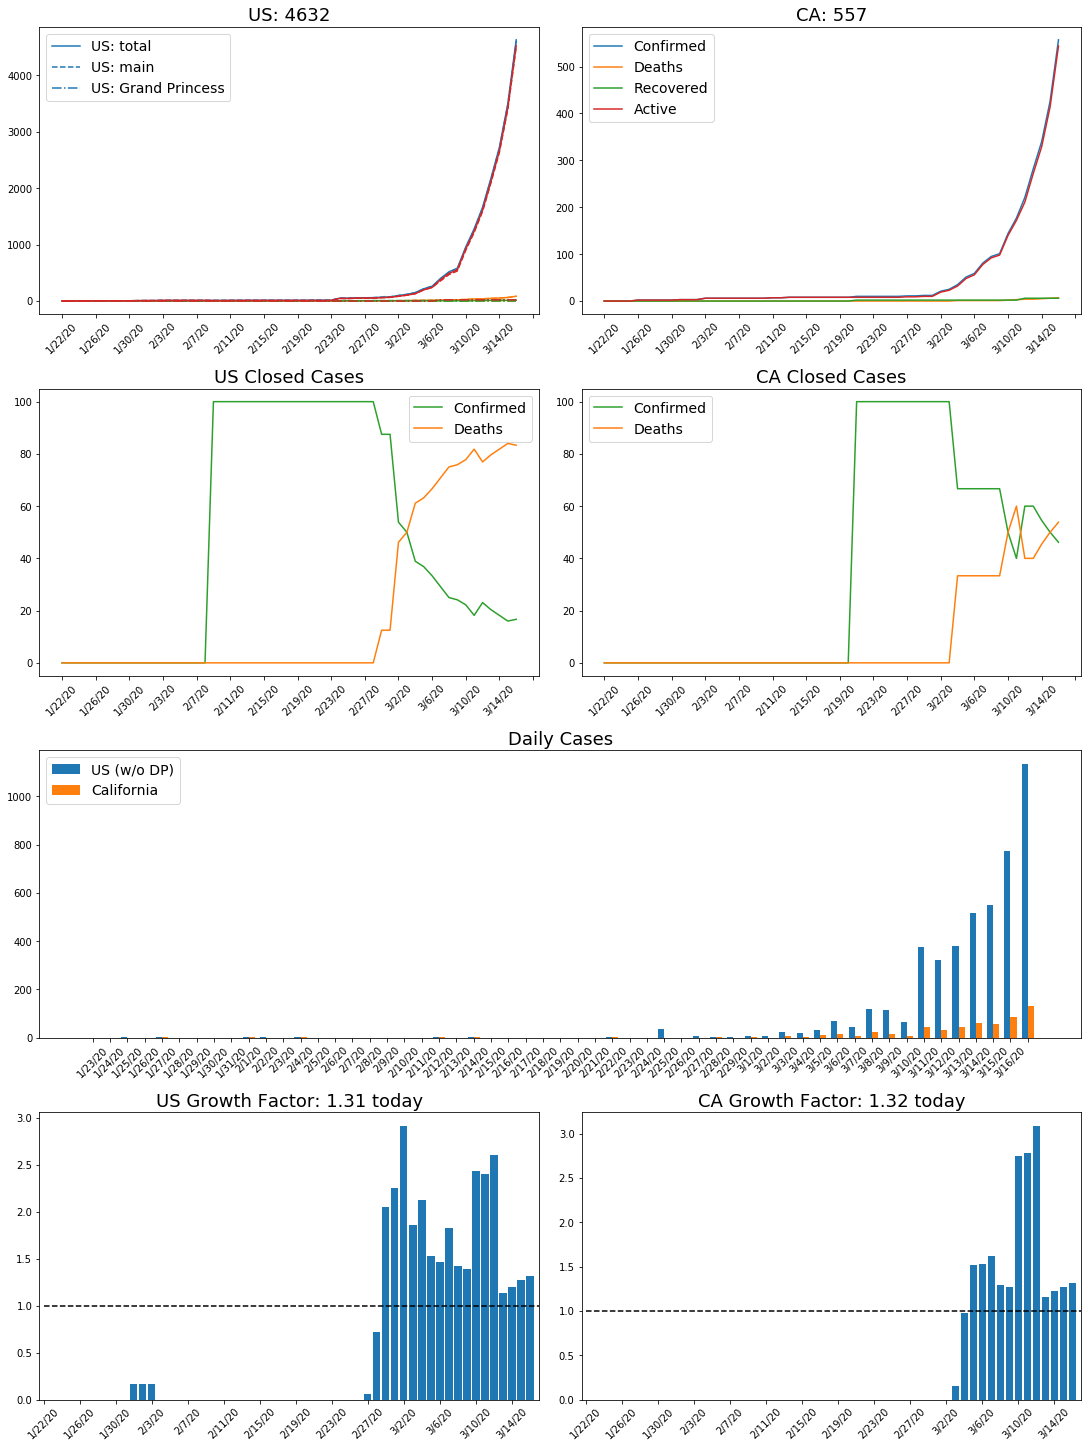

In [28]:
fig = plt.figure(figsize = (15, 20), constrained_layout=True)
gs = fig.add_gridspec(4,2)

### US confirmed/recovered/deaths/active
ax1 = fig.add_subplot(gs[0, 0])
for cat in cat_color:
    ax1.plot(df_US.loc[:,cat], color = cat_color[cat])
    ax1.plot(df_USmain.loc[:,cat], '--', color = cat_color[cat])
    ax1.plot(df_GP.loc[:,cat], '-.', color = cat_color[cat])
legend = ['US: total', 'US: main', 'US: Grand Princess']
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(legend, fontsize = 14)
ax1.set_title(f'US: {int(df_US.loc[time_str[-1], "Confirmed"])}', size = 18)

              
### Ca confirmed/recovered/deaths/active
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_CA[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = 14)
ax2.set_title(f'CA: {int(df_CA.loc[time_str[-1], "Confirmed"])}', size = 18)

### US Closed cases      
ax8 = fig.add_subplot(gs[1, 0])
ax8.plot(df_US.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_US.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(cat_cols, fontsize = 14)
ax8.set_title('US Closed Cases', size = 18)

### CA Closed cases
ax9 = fig.add_subplot(gs[1, 1])
ax9.plot(df_CA.Recovered_prop, color = cat_color['Recovered'])
ax9.plot(df_CA.Death_prop, color = cat_color['Deaths'])
ax9.xaxis.set_major_locator(myLocator)
ax9.tick_params(axis = 'x', labelrotation = 45)
ax9.legend(cat_cols, fontsize = 14)
ax9.set_title('CA Closed Cases', size = 18)
              
### Daily new cases              
ax3 = fig.add_subplot(gs[2, :])
# usmain_daily = df_USmain_sum.loc['Confirmed',:].to_numpy()[1:] - df_USmain_sum.loc['Confirmed',:].to_numpy()[0:-1] 
# ca_daily = df_Ca_sum.loc['Confirmed',:].to_numpy()[1:] - df_Ca_sum.loc['Confirmed',:].to_numpy()[0:-1] 
x = np.arange(len(time_str))
width = 0.35
rects1 = ax3.bar(x - width/2, df_USmain.loc[:,'Daily'], width = width)
rects2 = ax3.bar(x + width/2, df_CA.loc[:,'Daily'], width = width)
ax3.set_yscale('log')
# ax3.set_yscale('linear')
# ax3.set_ylim([0, 1000])
_ = ax3.set_xticks(x)
_ = ax3.set_xticklabels(time_str[1:])
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(['US (w/o DP)', 'California'], fontsize = 14)
ax3.set_title('Daily Cases', size = 18)

              
### US growth factors
ax4 = fig.add_subplot(gs[3, 0])
              
x = np.arange(len(time_str))
x1 = np.arange(0, len(time_str) + 2)
              
ax4.bar(x, df_USmain.GF_rolling)
ax4.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ax4.set_xlim([-0.5, len(time_str)])
ax4.tick_params(axis = 'x', labelrotation = 45)
_ = ax4.set_title(f'US Growth Factor: {df_USmain.GF_rolling[-1]:.2f} today', size = 18)

              
### CA growth factors
ax5 = fig.add_subplot(gs[3, 1])
              
ax5.bar(x, df_CA.GF_rolling)
ax5.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.set_xlim([-0.5, len(time_str)])
ax5.tick_params(axis = 'x', labelrotation = 45)
_ = ax5.set_title(f'CA Growth Factor: {df_CA.GF_rolling[-1]:.2f} today', size = 18)

In [29]:
df_US_1p3a = pd.read_csv('time_series_19-covid_US_1p3a.csv')

In [30]:
df_US_1p3a.to_csv('time_series_19-covid_US_1p3a.csv')

In [31]:
df_US_1p3a.set_index('Date', inplace = True)

In [32]:
x = np.arange(len(time_str))
y1 = df_US.loc[time_str, 'Confirmed'].to_list()
y2 = df_US_1p3a.loc[time_str, 'Confirmed'].to_list()

res = df_USmain[df_USmain.GF_rolling_thr != 0.0].bfill(axis=1).index[0]
# res = df_US[df_US.Confirmed >= 100].bfill(axis=1).index[0]
ind_t0 = max(0, time_str.index(res)-3)
t = np.arange(len(time_str))[ind_t0:]- ind_t0
p1_t = y1[ind_t0:]
p2_t = y2[ind_t0:]

In [33]:
popt_exp1, pcov_exp1 = opt.curve_fit(exp_growth,  t,  p1_t, maxfev = 10000)
popt_log1, pcov_log1 = opt.curve_fit(logistic_growth,  t,  p1_t, maxfev=100000)
popt_exp2, pcov_exp2 = opt.curve_fit(exp_growth,  t,  p2_t, maxfev = 10000)
popt_log2, pcov_log2 = opt.curve_fit(logistic_growth,  t,  p2_t, maxfev=100000)

Text(0.5, 1.0, 'US: growth rate 0.29/0.30')

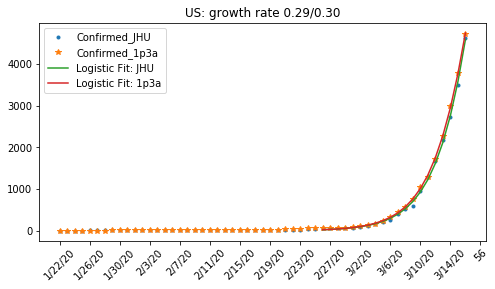

In [37]:
future = 0
x1 = np.arange((len(t) + future))

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
plt.plot(x, y1, '.')
plt.plot(x, y2, '*')
plt.plot(x1 + ind_t0, logistic_growth(x1, popt_log1[0], popt_log1[1], popt_log1[2]))
plt.plot(x1 + ind_t0, logistic_growth(x1, popt_log2[0], popt_log2[1], popt_log2[2]))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax.xaxis.set_major_locator(myLocator)
# ax.set_xlim(right = len(time_str))
# ax.set_ylim([0, np.ceil(y[-1]) + 500])
ax.set_yscale('linear')
ax.tick_params(axis = 'x', labelrotation = 45)
ax.legend(['Confirmed_JHU', 
           'Confirmed_1p3a', 
           'Logistic Fit: JHU', 
           'Logistic Fit: 1p3a'])
ax.set_title(f'US: growth rate {popt_log1[0]:.2f}/{popt_log2[0]:.2f}')

https://lmfit.github.io/lmfit-py/model.html

In [38]:
""" Mainland China """

' Mainland China '

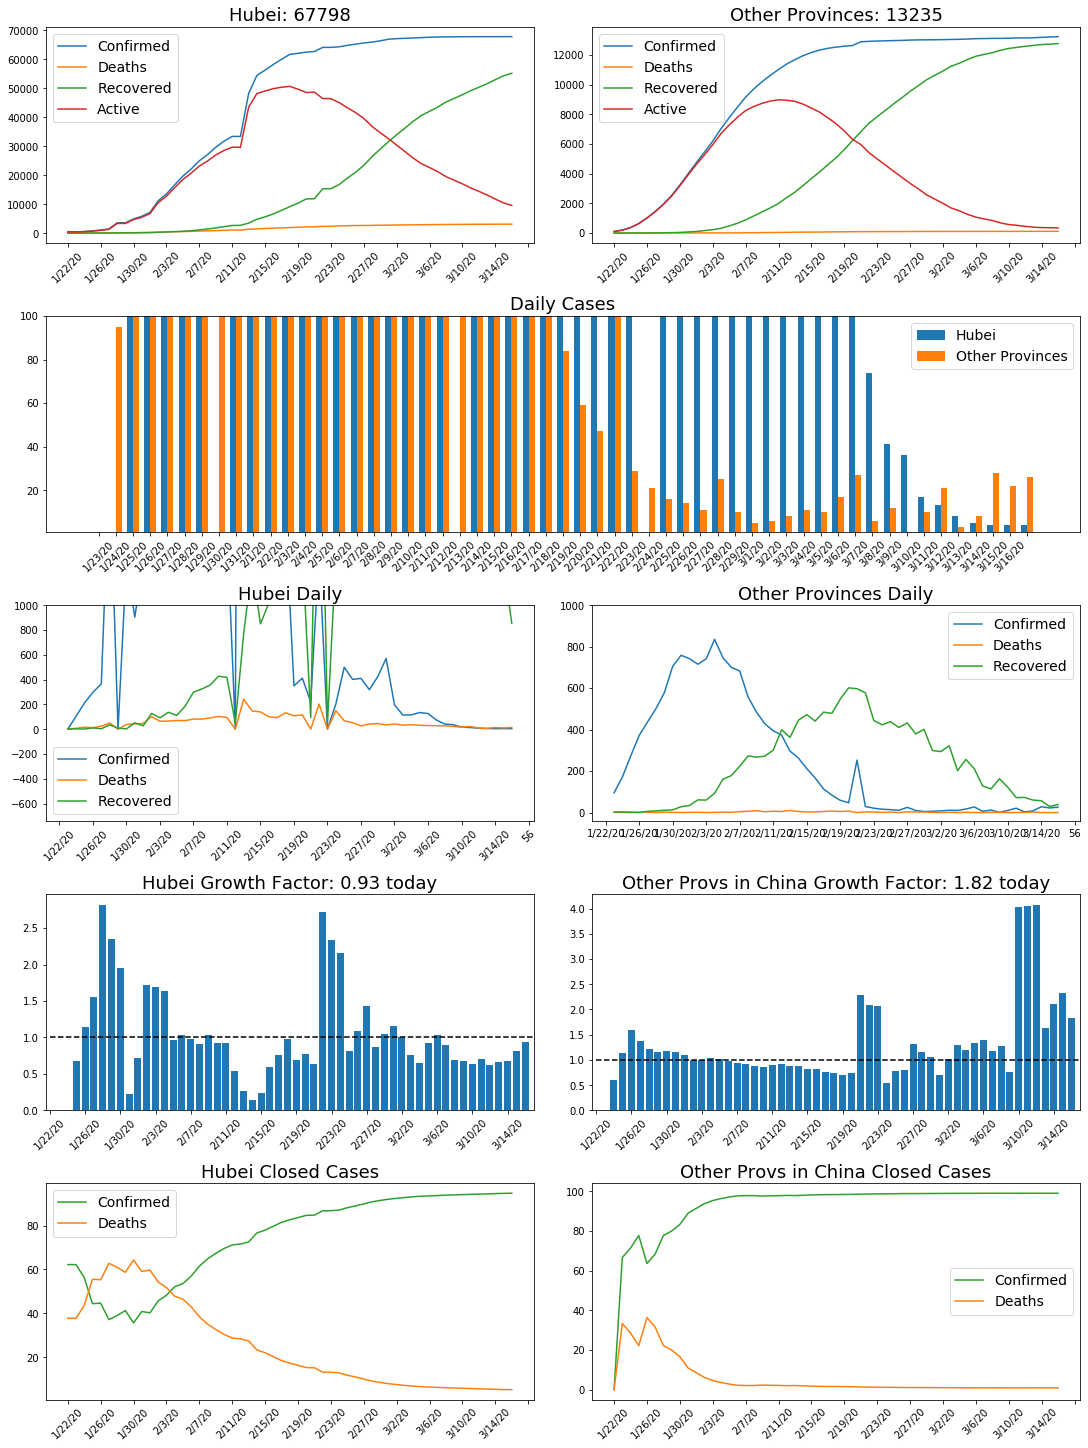

In [54]:
fig = plt.figure(figsize = (15, 20), constrained_layout=True)
gs = fig.add_gridspec(5,2)

### Hubei total confirmed/death/recovered
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_hb[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(cat_cols, fontsize = 14)
ax1.set_title(f'Hubei: {int(df_hb.loc[time_str[-1], "Confirmed"])}', size = 18)

              
### Other Provinces total confirmed/death/recovered
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_co[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = 14)
ax2.set_title(f'Other Provinces: {int(df_co.loc[time_str[-1], "Confirmed"])}', size = 18)

              
### Daily new cases              
ax3 = fig.add_subplot(gs[1, :])
# hubei_daily = hubei.loc['Confirmed',:].to_numpy()[1:] - hubei.loc['Confirmed',:].to_numpy()[:-1]
# co_daily = china_others.loc['Confirmed',:].to_numpy()[1:] - china_others.loc['Confirmed',:].to_numpy()[0:-1]
x = np.arange(len(time_str))
width = 0.35
rects1 = ax3.bar(x - width/2, df_hb.Daily, width = width)
rects2 = ax3.bar(x + width/2, df_co.Daily, width = width)
# ax3.set_yscale('log')
ax3.set_yscale('linear')
ax3.set_ylim([0, 100])
a = ax3.set_xticks(x)
a = ax3.set_xticklabels(time_str[1:])
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(['Hubei', 'Other Provinces'], fontsize = 14)
ax3.set_ylim(bottom = 10**-0.1)
ax3.set_title('Daily Cases', size = 18)

### Hubei daily confirmed/death/recovered              
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(df_hb[cat_cols[:-1]].diff())
ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ax4.set_ylim(top = 6000)
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.legend(cat_cols[:-1], fontsize = 14)
ax4.set_ylim(top = 1000)
ax4.set_title('Hubei Daily', size = 18)

### Other provinces daily confirmed/death/recovered              
ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(df_co[cat_cols[:-1]].diff())
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax4.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(cat_cols[:-1], fontsize = 14)
ax5.set_ylim(top = 1000)
ax5.set_title('Other Provinces Daily', size = 18)

### Hubei Growth Factor
ax6 = fig.add_subplot(gs[3, 0])
x = np.arange(0, len(time_str))
x1 = np.arange(0, len(time_str) + 2)

ax6.bar(x, df_hb.GF_rolling)
ax6.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.set_xlim([-0.5, len(x)])
ax6.tick_params(axis = 'x', labelrotation = 45)
_ = ax6.set_title(f'Hubei Growth Factor: {df_hb.GF_rolling[-1]:.2f} today', size = 18)

              
### Other Provinces Growth Factor
ax7 = fig.add_subplot(gs[3, 1])

ax7.bar(x, df_co.GF_rolling)
ax7.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax7.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax7.xaxis.set_major_locator(myLocator)
ax7.set_xlim([-0.5, len(x)])
ax7.tick_params(axis = 'x', labelrotation = 45)
_ = ax7.set_title(f'Other Provs in China Growth Factor: {df_co.GF_rolling[-1]:.2f} today', size = 18)

                    
### Hubei Closed cases      
ax8 = fig.add_subplot(gs[4, 0])
ax8.plot(df_hb.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_hb.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(cat_cols, fontsize = 14)
ax8.set_title('Hubei Closed Cases', size = 18)

### Hubei Closed cases      
ax9 = fig.add_subplot(gs[4, 1])
ax9.plot(df_co.Recovered_prop, color = cat_color['Recovered'])
ax9.plot(df_co.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax9.xaxis.set_major_locator(myLocator)
ax9.tick_params(axis = 'x', labelrotation = 45)
ax9.legend(cat_cols, fontsize = 14)
_ = ax9.set_title('Other Provs in China Closed Cases', size = 18)


In [40]:
x = np.arange(len(time_str))
y1 = df_hb.Confirmed.to_list()
y2 = df_co.Confirmed.to_list()
# popt_exp, pcov_exp = opt.curve_fit(exp_growth,  t,  p_t)
popt1, pcov1 = opt.curve_fit(logistic_growth,  x,  y1, maxfev=10000)
popt2, pcov2 = opt.curve_fit(logistic_growth,  x,  y2, maxfev=10000)

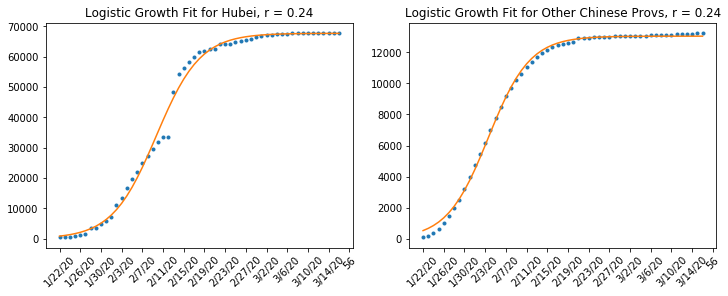

In [41]:
x1 = np.arange(len(x))

fig = plt.figure(figsize = (10, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
plt.plot(x, y1, '.')
plt.plot(x1, logistic_growth(x1, popt1[0], popt1[1], popt1[2]))
plt.title(f'Logistic Growth Fit for Hubei, r = {popt1[0]:.2f}')
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
# _ = ax1.set_xlim(right = len(time_str))


ax2 = fig.add_subplot(gs[0, 1])
plt.plot(x, y2, '.')
plt.plot(x, logistic_growth(x, popt2[0], popt2[1], popt2[2]))
plt.title(f'Logistic Growth Fit for Other Chinese Provs, r = {popt1[0]:.2f}')
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
# _ = ax2.set_xlim(right = len(time_str))

In [42]:
""" Outside Mainland China"""

' Outside Mainland China'

In [43]:
def get_growth_rate(ctry, df_confirmed, time_str):
    x = np.arange(len(time_str))
    y = df_confirmed.loc[ctry,time_str].to_list()

    ind_t0 = y.index(next(filter(lambda x: x!=0, y)))
    t = np.arange(len(time_str))[ind_t0:] - ind_t0
    p_t = df_confirmed.loc[ctry,time_str].to_numpy()[ind_t0:]
    popt_log, pcov_log = opt.curve_fit(logistic_growth,  t,  p_t, p0 = (0.1, 100, 1), maxfev=100000)    
    return popt_log[0]

In [44]:
df_confirmed = df_time_series.groupby('Category').get_group('Confirmed').groupby('Country/Region').sum()[time_str]
df_recovered = df_time_series.groupby('Category').get_group('Recovered').groupby('Country/Region').sum()[time_str]
df_deaths = df_time_series.groupby('Category').get_group('Deaths').groupby('Country/Region').sum()[time_str]
df_active = df_confirmed - (df_recovered + df_deaths)
df_confirmed['New_Today'] = df_confirmed[time_str[-1]] - df_confirmed[time_str[-2]]

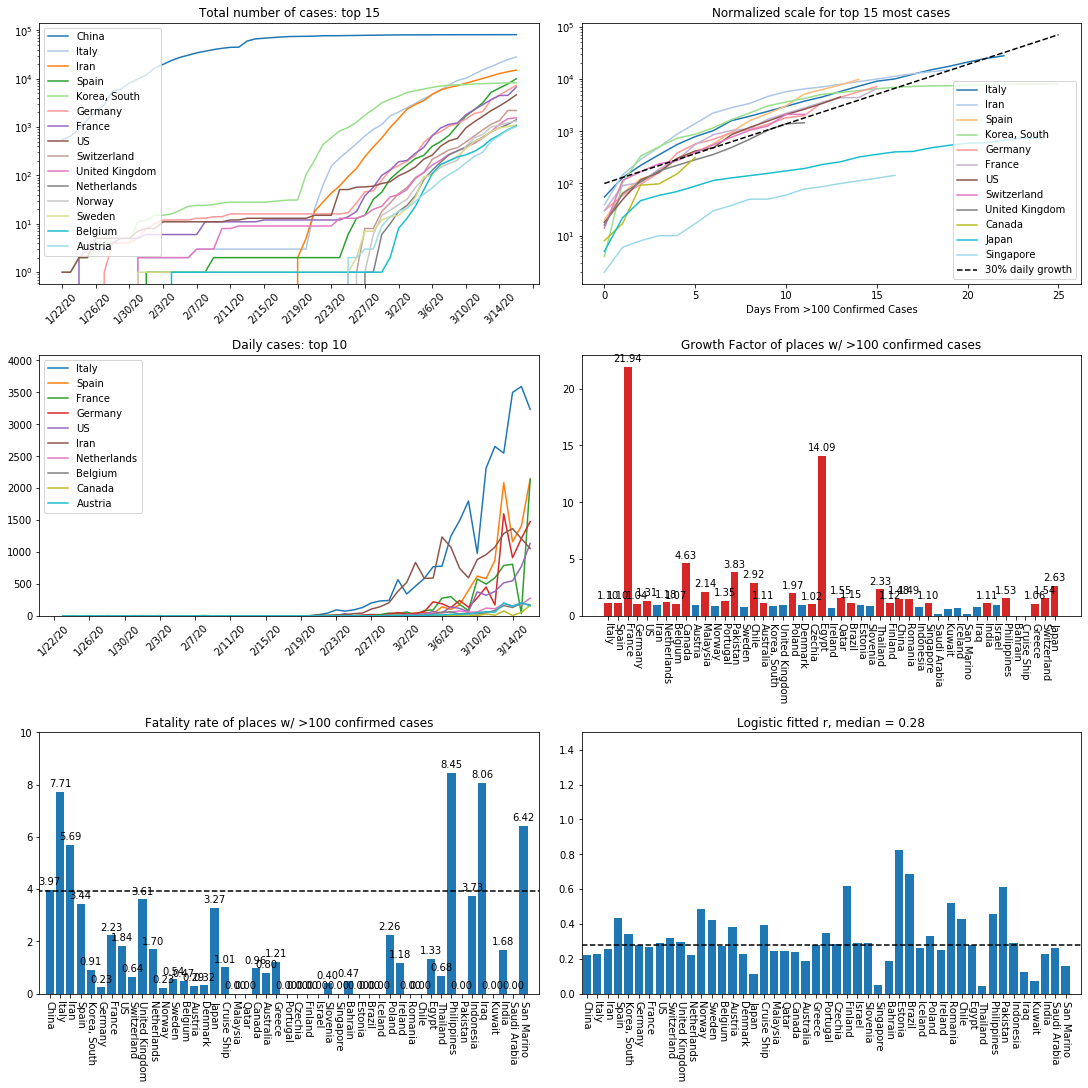

In [77]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(3, 2)

### total number
ax1 = fig.add_subplot(gs[0, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[0:15])
df_plot = df_confirmed.loc[countries,time_str]

colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
for i, ctr in enumerate(countries):
    ax1.plot(df_plot.loc[ctr,:], color = colors[i])

ax1.legend(countries)
ax1.set_yscale('log')
# plt.ylim(top = 2000)
ax1.set_title('Total number of cases: top 15')
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)

### normalize axis
ax2 = fig.add_subplot(gs[0, 1])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[1:10])
countries += ['Canada','Japan', 'Singapore']

df_plot = df_confirmed.loc[countries,time_str]


colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
max_x = 0
for i, ctr in enumerate(countries):
    xi = len(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy())
    ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy() - 100, color = colors[i])
    if(xi > max_x):
        max_x = xi
x = np.arange(max_x)
ax2.plot(x, 100 * (1.3) ** x, ls='--', color='k')

ax2.legend(countries + ['30% daily growth'])
ax2.set_yscale('log')
ax2.set_xlabel('Days From >100 Confirmed Cases')
ax2.set_title('Normalized scale for top 15 most cases')


### daily cases
ax3 = fig.add_subplot(gs[1, 0])

df_confirmed.sort_values(by = 'New_Today', inplace = True, ascending=False)
countries = list(df_confirmed.index[0:10])
# countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 100]

data = df_confirmed.loc[countries,time_str].to_numpy().transpose()
new_today = data[1:,:] - data[0:-1,:]
data_max = np.ceil(np.max(new_today.flatten())) + 500
x = np.arange(1, len(time_str))

colors = pl.cm.tab10(np.linspace(0,1,len(countries)))
for i, ctr in enumerate(countries):
    ax3.plot(x, new_today[:,i], color = colors[i])

ax3.legend(countries, loc = 'upper left')
ax3.set_yscale('linear')
ax3.set_ylim([0, data_max])
a = ax3.set_title('Daily cases: top 10')
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.set_xlim(right = len(time_str))
ax3.tick_params(axis = 'x', labelrotation = 45)

### growth factors
df_confirmed.sort_values(by = 'New_Today', inplace = True, ascending=False)
# countries = list(df_confirmed.index[0:10])
countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 100]

df_gf = df_confirmed.loc[countries,time_str].transpose()
for ctry in countries:
    df_ctry = pd.DataFrame(df_confirmed.loc[ctry,time_str])
    df_ctry = reshape_dataframe(df_ctry, time_str)
    df_gf[ctry] = df_ctry.GF_rolling

ax4 = fig.add_subplot(gs[1, 1])

# colors = pl.cm.tab10(np.linspace(0,1,len(countries)))
# for i, ctr in enumerate(countries):
#     ax4.plot(df_gf[ctr], color = colors[i])
# x = np.arange(-1, len(time_str)+2)
# ax4.plot(x, np.full(len(x), 1), '--', color = 'k')

# ax4.legend(countries, loc = 'upper left')
# ax4.set_yscale('linear')
# ax4.set_ylim([0, 5])
# a = ax4.set_title('Growth Factors: top 10 countries with most new cases')
# ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(4)
# ax4.xaxis.set_major_locator(myLocator)
# ax4.set_xlim(left = -1, right = len(time_str))
# ax4.tick_params(axis = 'x', labelrotation = 45)
x = np.arange(len(countries))
y = df_gf.loc[time_str[-1],:]

rects = ax4.bar(x[y<=1], y[y<=1], color = 'tab:blue')
rects = ax4.bar(x[y>1], y[y>1], color = 'tab:red')
a = ax4.set_xticks(x)
a = ax4.set_xticklabels(countries)
ax4.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax4, '{:.2f}')
ymax = np.ceil(np.max(y)) + 1
ax4.set_ylim([0, ymax])
a = ax4.set_title('Growth Factor of places w/ >100 confirmed cases')



# growth_factors = (df_confirmed.loc[countries, time_str[2:]].to_numpy() - df_confirmed.loc[countries, time_str[1:-1]].to_numpy()) \
# /(df_confirmed.loc[countries, time_str[1:-1]].to_numpy() - df_confirmed.loc[countries, time_str[:-2]].to_numpy())
# y = (growth_factors[:,-1] + growth_factors[:,-2])/2
# y[~np.isfinite(y)] = 0
# y = df_gf.loc[time_str[-1],:]

# # rects = ax5.bar(x[y<=1], y[y<=1], color = 'tab:blue')
# # rects = ax5.bar(x[y>1], y[y>1], color = 'tab:red')

# a = ax5.set_xticks(x)
# a = ax5.set_xticklabels(countries)
# ax5.tick_params(axis = 'x', labelrotation = -90)
# autolabel(rects, ax5, '{:.2f}')
# ymax = np.ceil(np.max(y)) + 1
# ax5.set_ylim([0, ymax])
# a = ax5.set_title('Growth Factor of places w/ >100 confirmed cases')

### fatality rate
ax4 = fig.add_subplot(gs[2, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 100]
fatal_rates = df_deaths.loc[countries,time_str] / df_confirmed.loc[countries,time_str] * 100
x = np.arange(len(countries))
x1 = np.arange(-2, len(x)+2)
fr_total = df_total.Fatality_rate[-1]

rects = ax4.bar(x, fatal_rates.loc[:,time_str[-1]])
ax4.plot(x1, np.full(len(x1), fr_total), '--', color = 'k')
a = ax4.set_xticks(x)
a = ax4.set_xticklabels(countries)
ax4.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax4, '{:.2f}')
ymax = np.ceil(np.max(fatal_rates.loc[:,time_str[-1]]) + 1)
ax4.set_ylim([0, ymax])
ax4.set_xlim([-1, len(x) + 0.5])
a = ax4.set_title('Fatality rate of places w/ >100 confirmed cases')


## r for logistic growth fit
ax6 = fig.add_subplot(gs[2, 1])
x = np.arange(len(countries))
x1 = np.arange(-2, len(x)+2)
y = []
for i in x:
    ctry = countries[i]
    y.append(get_growth_rate(ctry, df_confirmed, time_str))
y = np.array(y)
rects = ax6.bar(x, y)
ax6.plot(x1, np.full(len(x1), np.median(y)), '--', color = 'k')
a = ax6.set_xticks(x)
a = ax6.set_xticklabels(countries)
ax6.tick_params(axis = 'x', labelrotation = -90)
# autolabel(rects, ax6, '{:.2f}')
# ymax = np.ceil(np.max(y)) + 0.5
ymax = 1.5
ax6.set_ylim([0, ymax])
ax6.set_xlim([-0.5, len(x) + 0.5])
a = ax6.set_title(f'Logistic fitted r, median = {np.median(y):.2f}')

In [46]:
### world bar graph

In [47]:
df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_recovered.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)

In [48]:
# recovered = df_recovered.loc[:,time_str[-1]].to_numpy()
# deaths = df_deaths.loc[:,time_str[-1]].to_numpy()
# confirmed = df_confirmed.loc[:,time_str[-1]].to_numpy()
# x = np.arange(len(confirmed))

# fig, ax = plt.subplots(1,1,figsize = (40,6))
# rects = ax.bar(x, confirmed)
# plt.bar(x, deaths)
# plt.bar(x, recovered, bottom = deaths)

# plt.legend(['Confirmed', 'Recovered', 'Deaths'])
# plt.yscale('log')
# plt.ylim(bottom = 10**-0.1)
# plt.xlim([-1, len(x)])
# a = ax.set_xticks(x)
# a = ax.set_xticklabels(list(df_confirmed.index))
# a = plt.xticks(rotation=-90)
# a = plt.title(f'Total {len(df_confirmed.index)-4} Countries affected', fontsize = 18)
# autolabel(rects, ax, '{:.0f}')

In [49]:
""" Specific Countries """

' Specific Countries '

In [80]:
ctry = 'Philippines'


In [81]:
df_ctry = pd.concat([df_confirmed.loc[ctry,time_str], 
                     df_deaths.loc[ctry,time_str],
                     df_recovered.loc[ctry,time_str]],
                    axis = 1)
df_ctry.columns = cat_cols[:3]
df_ctry = df_ctry.transpose()
df_ctry = reshape_dataframe(df_ctry, time_str)

In [82]:
x = np.arange(len(time_str))
y = df_ctry.Confirmed.to_list()

res = df_ctry[df_ctry.GF_rolling_thr != 0.0].bfill(axis=1).index[0]
ind_t0 = max(0, time_str.index(res)-3)
t = np.arange(len(time_str))[ind_t0:]- ind_t0
pt = y[ind_t0:]

popt_exp, pcov_exp = opt.curve_fit(exp_growth,  t,  pt, maxfev = 10000)
popt_log, pcov_log = opt.curve_fit(logistic_growth,  t,  pt, p0 = (0.1, 100, 1), maxfev=100000)


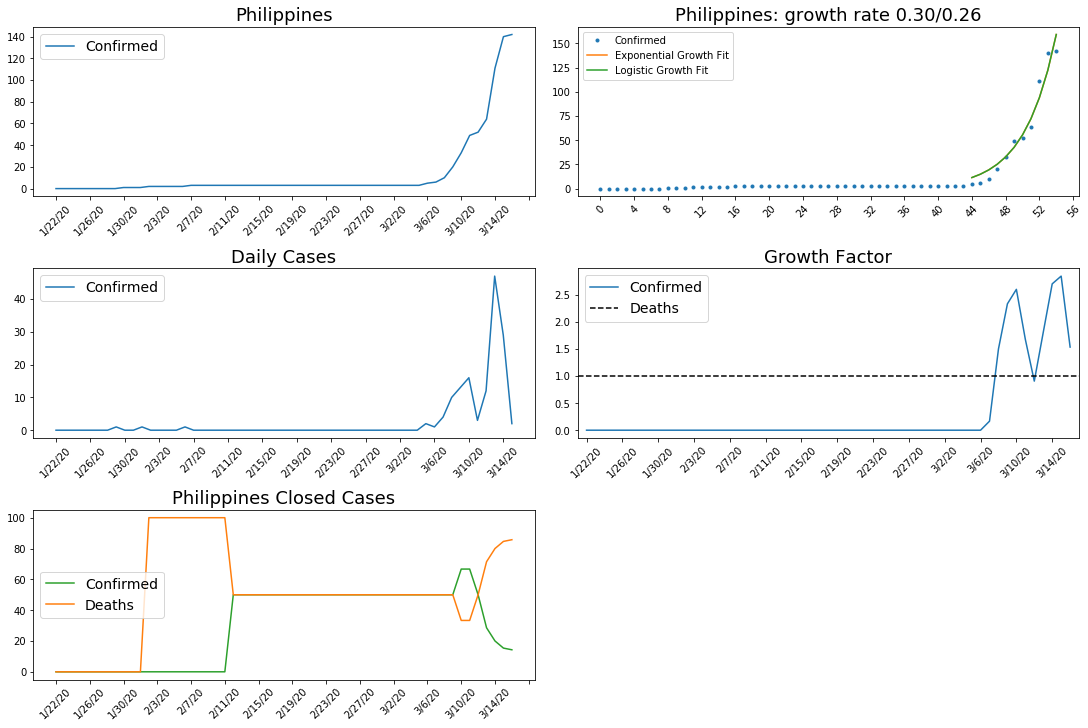

In [83]:
future = 0

fig = plt.figure(figsize = (15, 10), constrained_layout=True)
gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_confirmed.loc[ctry, time_str].transpose())
# ax1.plot(df_deaths.loc[ctry, time_str].transpose())
# ax1.plot(df_recovered.loc[ctry, time_str].transpose())
# ax1.plot(df_active.loc[ctry, time_str].transpose())
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(['Confirmed', 'Deaths', 'Recovered', 'Active'], fontsize = 14)
ax1.set_title(ctry, size = 18)

ax2 = fig.add_subplot(gs[0, 1])
x = np.arange(len(time_str))
x1 = np.arange(len(t) + future)
ax2.plot(x, y, '.')
if(future == 0):
    ax2.plot(x1 + ind_t0, exp_growth(x1, popt_exp[0], popt_exp[1]))
ax2.plot(x1 + ind_t0, logistic_growth(x1, popt_log[0], popt_log[1], popt_log[2]))
ax2.set_yscale('linear')
ax2.legend(['Confirmed', 'Exponential Growth Fit', 'Logistic Growth Fit'])
ax2.set_title(f'{ctry}: growth rate {popt_exp[0]:.2f}/{popt_log[0]:.2f}', fontsize = 18)
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)


ax5 = fig.add_subplot(gs[1, 0])
ax5.plot(df_confirmed.loc[ctry, time_str[1:]].transpose().to_numpy() - df_confirmed.loc[ctry, time_str[:-1]].transpose().to_numpy())
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(cat_cols, fontsize = 14)
ax5.set_title('Daily Cases', size = 18)

ax3 = fig.add_subplot(gs[1, 1])
x = np.arange(-1, len(time_str)+2)
ax3.plot(df_ctry.GF_rolling)
ax3.plot(x, np.full(len(x), 1), '--', color = 'k')
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(cat_cols, fontsize = 14)
ax3.set_title('Growth Factor', size = 18)
ax3.set_xlim([-1, len(time_str)])

ax8 = fig.add_subplot(gs[2, 0])
ax8.plot(df_ctry.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_ctry.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(cat_cols, fontsize = 14)
_ = ax8.set_title(f'{ctry} Closed Cases', size = 18)
